### Analysis of Background Swap Experiment Results

The code below processes SVM classification results from all five experimental settings across PIFiA, Paired Cell Inpainting, and DeepLoc. For each experiment and model, it calculates the mean localization classification accuracy and its uncertainty, reported as three times the standard error across localization classes. This summary corresponds to Table 1 of the paper.

In [23]:
import os
import pandas as pd
import numpy as np

# --- Constants ---
LOC_KEYS = [
    "actin", "bud neck", "cell periphery", "cytoplasm", "endosome", "ER", "Golgi", "mitochondrion",
    "nucleus", "nuclear periphery", "nucleolus", "spindle pole", "peroxisome", "vacuolar membrane", "vacuole"
]

CSV_CONFIGS = [
    {"base_dir": "results/pifia", "label": "PIFiA"},
    {"base_dir": "results/pci", "label": "Paired Cell Inpainting"},
    {"base_dir": "results/deeploc", "label": "DeepLoc"},
]

EXPERIMENT_LABELS = {
    "base_accuracy": "Baseline",
    "mask_accuracy": "Masked Background",
    "batch_accuracy": "Cell-Free Different Localization Swap",
    "same_accuracy": "Same Localization Swap",
    "diff_accuracy": "Different Localization Swap"
}

def get_localization_means(df, value_col):
    seen = set()
    rows = []
    for _, row in df.iterrows():
        loc1, loc2 = row['Location1'], row['Location2']
        pair = tuple(sorted([loc1, loc2]))
        if pair in seen: continue
        seen.add(pair)
        for loc in pair:
            if loc in LOC_KEYS:
                rows.append({'Localization': loc, value_col: row[value_col]})
    return pd.DataFrame(rows).groupby("Localization")[value_col].mean()

def load_experiment_data(base_dir):
    data = {}
    try:
        # Baseline
        df = pd.read_csv(f"{base_dir}/results_base.csv")
        data["base_accuracy"] = df.groupby("Location1")["Accuracy"].mean()

        # Masked
        df = pd.read_csv(f"{base_dir}/results_mask.csv")
        data["mask_accuracy"] = df.groupby("Location1")["Accuracy"].mean()

        # Cell-Free (filtered)
        df = pd.read_csv(f"{base_dir}/results_batch.csv")
        df = df[(df["Background"] != df["Location1"]) & (df["Background"] != df["Location2"])]
        data["batch_accuracy"] = get_localization_means(df, "Accuracy")

        # Diff Loc (filtered)
        df = pd.read_csv(f"{base_dir}/results_diff.csv")
        df = df[(df["Background"] != df["Location1"]) & (df["Background"] != df["Location2"])]
        data["diff_accuracy"] = get_localization_means(df, "Accuracy")

        # Same Loc
        df = pd.read_csv(f"{base_dir}/results_same.csv")
        df = df.groupby(["Location1", "Location2"])["Accuracy"].mean().reset_index()
        df = pd.melt(df, id_vars=["Accuracy"], value_vars=["Location1", "Location2"],
                     var_name="LocType", value_name="Localization")
        data["same_accuracy"] = df.groupby("Localization")["Accuracy"].mean()
    except Exception as e:
        print(f"Error loading {base_dir}: {e}")
    return data

# --- Main Output ---
for cfg in CSV_CONFIGS:
    results = load_experiment_data(cfg["base_dir"])
    if not results:
        continue

    print(f"\n{'='*80}")
    print(f"{cfg['label']}".center(80))
    print(f"{'='*80}")

    for key, label in EXPERIMENT_LABELS.items():
        accs = results.get(key)
        if accs is None: continue
        accs = accs.loc[accs.index.intersection(LOC_KEYS)]  # keep only valid localizations
        mean = accs.mean()
        se = accs.std(ddof=1) / np.sqrt(len(accs))
        print(f"{label:<40} {mean:.3f} ± {3*se:.3f}")



                                     PIFiA                                      
Baseline                                 0.946 ± 0.020
Masked Background                        0.883 ± 0.023
Cell-Free Different Localization Swap    0.902 ± 0.017
Same Localization Swap                   0.939 ± 0.013
Different Localization Swap              0.843 ± 0.022

                             Paired Cell Inpainting                             
Baseline                                 0.916 ± 0.025
Masked Background                        0.869 ± 0.029
Cell-Free Different Localization Swap    0.876 ± 0.019
Same Localization Swap                   0.930 ± 0.016
Different Localization Swap              0.772 ± 0.026

                                    DeepLoc                                     
Baseline                                 0.713 ± 0.029
Masked Background                        0.677 ± 0.029
Cell-Free Different Localization Swap    0.689 ± 0.023
Same Localization Swap                 

The below code code generates the two plots shown in Figure 2 of the paper, comparing localization classification accuracy under different swapped background settings (masked, cell-free different localization, same localization, different localization) across models.

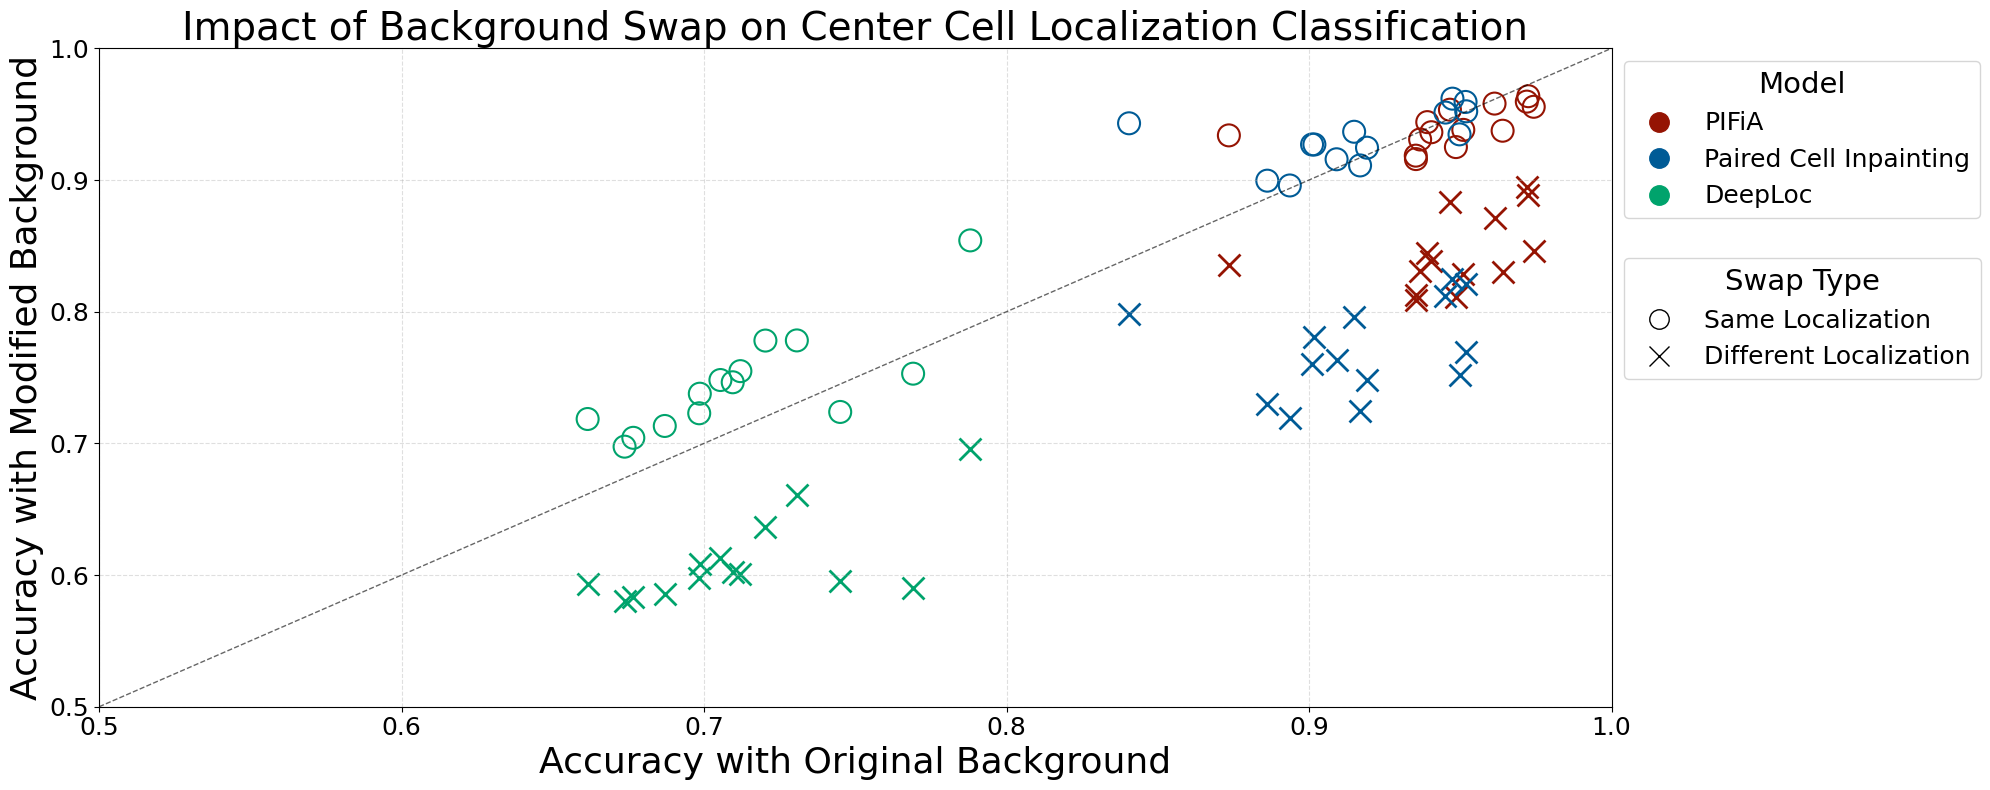

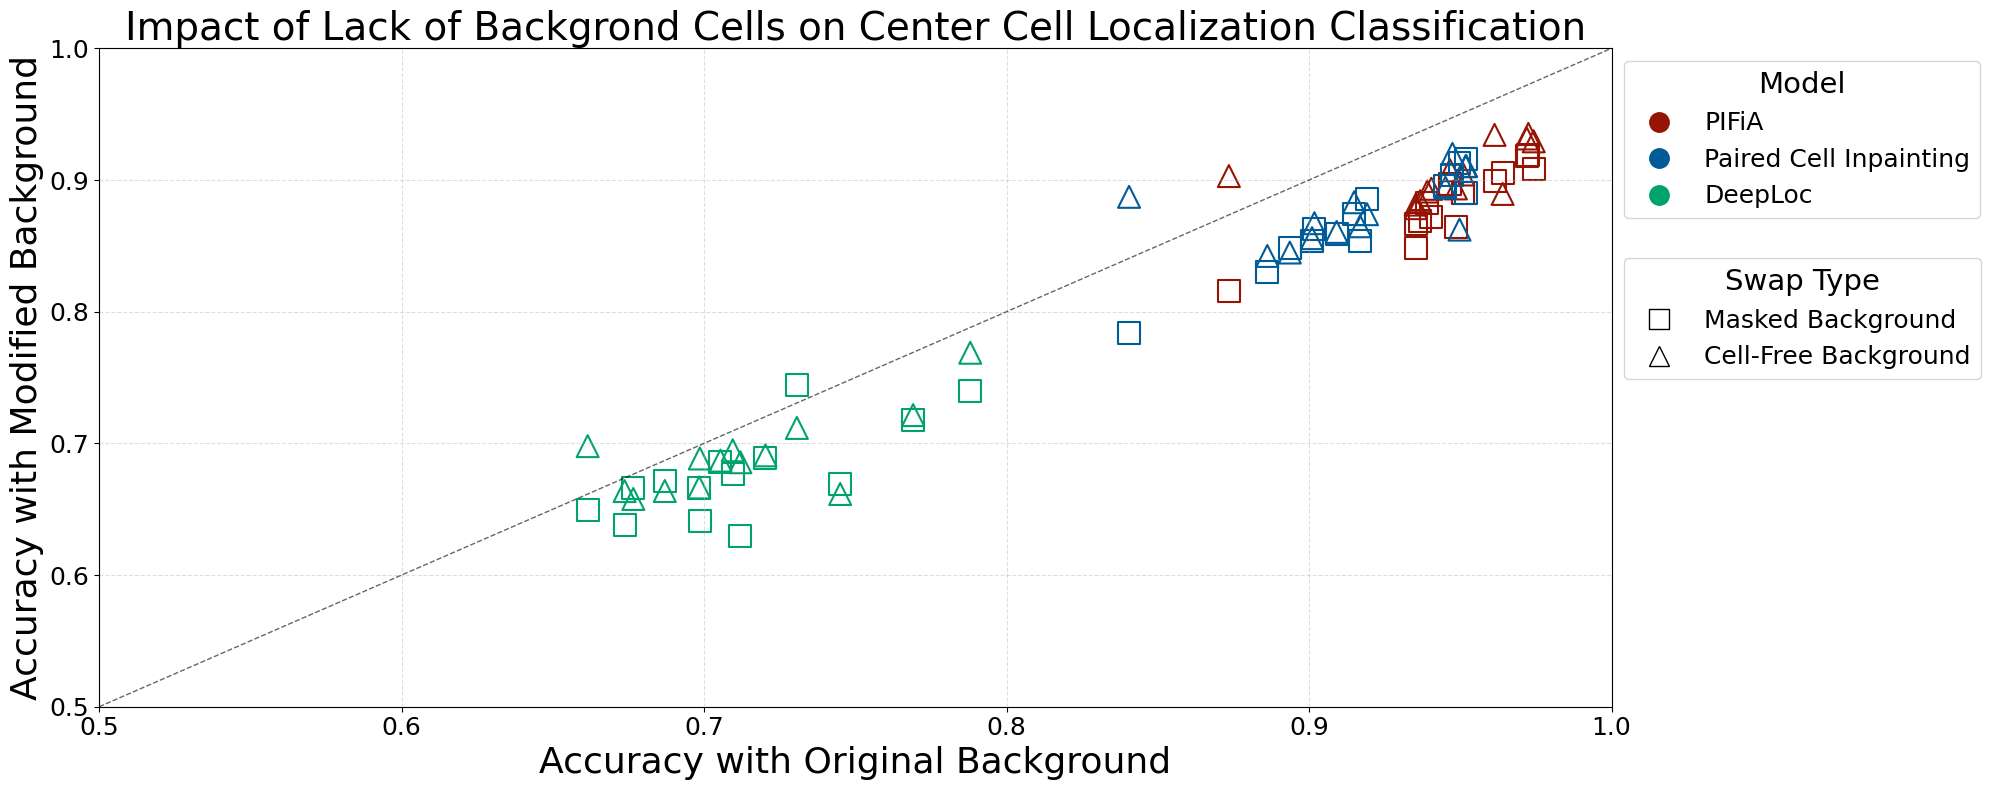

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

# --- Constants ---
LOC_KEYS = [
    "actin", "bud neck", "cell periphery", "cytoplasm", "endosome", "ER", "Golgi", "mitochondrion",
    "nucleus", "nuclear periphery", "nucleolus", "spindle pole", "peroxisome", "vacuolar membrane", "vacuole"
]

CSV_CONFIGS = [
    {"base_dir": "results/pifia", "label": "PIFiA", "color": "#951403"},
    {"base_dir": "results/pci", "label": "Paired Cell Inpainting", "color": "#005b96"},
    {"base_dir": "results/deeploc", "label": "DeepLoc", "color": "#00A36C"},
]

# --- Helper Functions ---
def aggregate_pairwise_results(df, value_col='Accuracy'):
    seen = set()
    agg = []
    for _, row in df.iterrows():
        loc1, loc2 = row['Location1'], row['Location2']
        pair = tuple(sorted([loc1, loc2]))
        if pair not in seen:
            seen.add(pair)
            for loc in pair:
                if loc in LOC_KEYS:
                    agg.append({'Location1': loc, value_col: row[value_col]})
    return pd.DataFrame(agg).groupby('Location1').agg({value_col: 'mean'}).reset_index()

def load_grouped_data(base_dir):
    def safe_load(path, group_col='Location1', new_col='Accuracy'):
        df = pd.read_csv(path)
        return df.groupby(group_col).agg({new_col: 'mean'}).reset_index()

    data = {}
    try:
        data["base"] = safe_load(f"{base_dir}/results_base.csv").rename(columns={'Accuracy': 'base_accuracy'})
        data["mask"] = safe_load(f"{base_dir}/results_mask.csv").rename(columns={'Accuracy': 'mask_accuracy'})

        df_batch = pd.read_csv(f"{base_dir}/results_batch.csv")
        df_batch = df_batch[(df_batch["Background"] != df_batch["Location1"]) & (df_batch["Background"] != df_batch["Location2"])]
        data["batch"] = aggregate_pairwise_results(df_batch, 'Accuracy').rename(columns={'Accuracy': 'batch_accuracy'})

        df_diff = pd.read_csv(f"{base_dir}/results_diff.csv")
        df_diff = df_diff[(df_diff["Background"] != df_diff["Location1"]) & (df_diff["Background"] != df_diff["Location2"])]
        data["diff"] = aggregate_pairwise_results(df_diff, 'Accuracy').rename(columns={'Accuracy': 'diff_accuracy'})

        df_same = pd.read_csv(f"{base_dir}/results_same.csv")
        grouped = df_same.groupby(['Location1', 'Location2']).agg(mean_accuracy=('Accuracy', 'mean')).reset_index()
        melted = pd.melt(
            grouped,
            id_vars=['mean_accuracy'],
            value_vars=['Location1', 'Location2'],
            var_name='LocType',
            value_name='LocKey'  # prevents FutureWarning
        ).rename(columns={'LocKey': 'Location1'})
        data["same"] = melted.groupby('Location1').agg(same_accuracy=('mean_accuracy', 'mean')).reset_index()
    except Exception as e:
        print(f"Error loading data from {base_dir}: {e}")
        return None
    return data

def merge_experiment_results(grouped, keys):
    merged = grouped["base"]
    for key in keys:
        if key in grouped:
            merged = merged.merge(grouped[key], on="Location1", how="inner")
    return merged.dropna()

# --- Plotting Utilities ---
def finalize_plot(title, xlabel, ylabel, markers):
    lims = [0.5, 1.0]
    plt.plot(lims, lims, 'k--', alpha=0.6, linewidth=1)
    plt.xlim(lims)
    plt.ylim(lims)
    plt.xlabel(xlabel, fontsize=26)
    plt.ylabel(ylabel, fontsize=26)
    plt.title(title, fontsize=28)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.grid(True, linestyle='--', alpha=0.4)

    # Swap-type legend
    swap_handles = [
        Line2D([0], [0], marker=m, linestyle='None', label=l,
               markerfacecolor='none' if m != 'x' else 'black',
               markeredgecolor='black', markersize=14, linewidth=2 if m == 'x' else 1)
        for m, l in markers
    ]
    legend1 = plt.legend(handles=swap_handles, loc='upper left', bbox_to_anchor=(1, 0.7),
                         fontsize=18, title="Swap Type", title_fontsize=21, frameon=True)
    plt.gca().add_artist(legend1)

    # Model legend
    model_handles = [
        Line2D([0], [0], marker='o', linestyle='None', color=cfg["color"], label=cfg["label"],
               markerfacecolor=cfg["color"], markersize=14)
        for cfg in CSV_CONFIGS
    ]
    plt.legend(handles=model_handles, loc='upper left', bbox_to_anchor=(1, 1.0),
               fontsize=18, title="Model", title_fontsize=21, frameon=True)

    plt.tight_layout()
    plt.show()

# --- Main Plot Functions ---
def plot_masked_vs_cellfree_background_swap():
    plt.figure(figsize=(20, 8))
    for cfg in CSV_CONFIGS:
        grouped = load_grouped_data(cfg["base_dir"])
        if not grouped: continue

        merged = merge_experiment_results(grouped, ["mask", "batch"])
        plt.scatter(merged['base_accuracy'], merged['mask_accuracy'], marker='s', s=250,
                    facecolors='none', edgecolors=cfg["color"], linewidths=1.5,
                    label=f"{cfg['label']} (Masked)")
        plt.scatter(merged['base_accuracy'], merged['batch_accuracy'], marker='^', s=250,
                    facecolors='none', edgecolors=cfg["color"], linewidths=1.5,
                    label=f"{cfg['label']} (Batch)")

    finalize_plot(
        title="Impact of Lack of Backgrond Cells on Center Cell Localization Classification",
        xlabel="Accuracy with Original Background",
        ylabel="Accuracy with Modified Background",
        markers=[
            ('s', 'Masked Background'),
            ('^', 'Cell-Free Background')
        ]
    )

def plot_same_vs_different_localization_background_swap():
    plt.figure(figsize=(20, 8))
    for cfg in CSV_CONFIGS:
        grouped = load_grouped_data(cfg["base_dir"])
        if not grouped: continue

        merged = merge_experiment_results(grouped, ["same", "diff"])
        plt.scatter(merged['base_accuracy'], merged['same_accuracy'], marker='o', s=250,
                    facecolors='none', edgecolors=cfg["color"], linewidths=1.5,
                    label=f"{cfg['label']} (Same Loc)")
        plt.scatter(merged['base_accuracy'], merged['diff_accuracy'], marker='x', s=250,
                    color=cfg["color"], linewidths=2,
                    label=f"{cfg['label']} (Diff Loc)")

    finalize_plot(
        title="Impact of Background Swap on Center Cell Localization Classification",
        xlabel="Accuracy with Original Background",
        ylabel="Accuracy with Modified Background",
        markers=[
            ('o', 'Same Localization'),
            ('x', 'Different Localization')
        ]
    )

# --- Create Plots ---
plot_same_vs_different_localization_background_swap()
plot_masked_vs_cellfree_background_swap()

